# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 24 14:32:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P0               40W /  N/A|   4387MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNet V2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2121 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.9225
Epoch 1: val_accuracy improved from -inf to 0.65054, saving model to Apple_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 69s 154ms/step - loss: 0.3631 - accuracy: 0.9225 - val_loss: 1.7132 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9623
Epoch 2: val_accuracy did not improve from 0.65054
401/401 [==============================] - 44s 110ms/step - loss: 0.1205 - accuracy: 0.9623 - val_loss: 5.1806 - val_accuracy: 0.4071 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9745
Epoch 3: val_accuracy did not improve from 0.65054
401/401 [==============================] - 45s 112ms/step - loss: 0.0822 - accuracy: 0.9745 - val_loss: 1.0458 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9802
Epoch 4: val_accuracy improved from 0.65054 to 0.93412, saving model to Apple_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 60s 149ms/step - loss: 0.0660 - accuracy: 0.9802 - val_loss: 0.1808 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9748
Epoch 5: val_accuracy did not improve from 0.93412
401/401 [==============================] - 44s 110ms/step - loss: 0.0828 - accuracy: 0.9748 - val_loss: 0.4727 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9792
Epoch 6: val_accuracy did not improve from 0.93412
401/401 [==============================] - 44s 110ms/step - loss: 0.0627 - accuracy: 0.9792 - val_loss: 0.4201 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9777
Epoch 7: val_accuracy did not improve from 0.93412
401/401 [==============================] - 44s 109ms/step - loss: 0.0762 - accuracy: 0.9777 - val_loss: 1.8865 - va

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 61s 151ms/step - loss: 0.0191 - accuracy: 0.9930 - val_loss: 0.0361 - val_accuracy: 0.9897 - lr: 1.0000e-04
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9950
Epoch 12: val_accuracy improved from 0.98971 to 0.99434, saving model to Apple_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 60s 150ms/step - loss: 0.0139 - accuracy: 0.9950 - val_loss: 0.0150 - val_accuracy: 0.9943 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9954
Epoch 13: val_accuracy improved from 0.99434 to 0.99794, saving model to Apple_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 59s 148ms/step - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.0063 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9971
Epoch 14: val_accuracy improved from 0.99794 to 0.99949, saving model to Apple_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model1_Based_Non_Augmented\assets


401/401 [==============================] - 61s 151ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0050 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9968
Epoch 15: val_accuracy did not improve from 0.99949
401/401 [==============================] - 45s 111ms/step - loss: 0.0112 - accuracy: 0.9968 - val_loss: 0.0032 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9979
Epoch 16: val_accuracy did not improve from 0.99949
401/401 [==============================] - 44s 110ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.0058 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9986
Epoch 17: val_accuracy did not improve from 0.99949
401/401 [==============================] - 45s 111ms/step - loss: 0.0040 - accuracy: 0.9986 - val

Text(0.5, 1.0, 'Training and validation loss DIY Model')

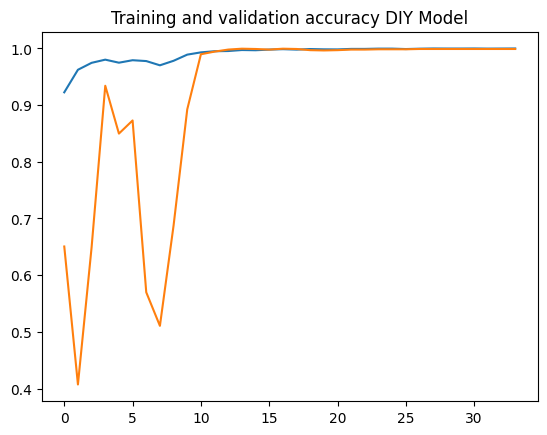

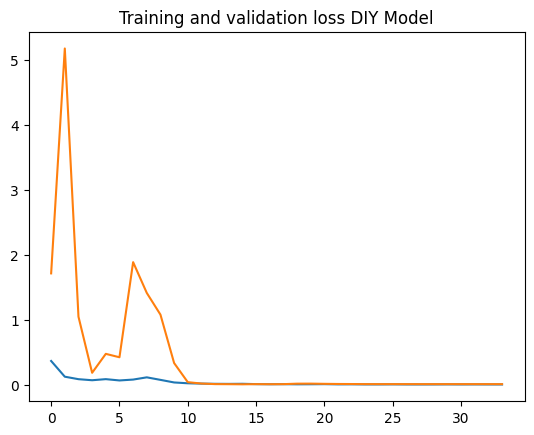

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

## MobileNet V2 Model 2

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [13]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2121 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9379
Epoch 1: val_accuracy improved from -inf to 0.26763, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 63s 149ms/step - loss: 0.2144 - accuracy: 0.9379 - val_loss: 14.1934 - val_accuracy: 0.2676 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9698
Epoch 2: val_accuracy improved from 0.26763 to 0.31961, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 59s 146ms/step - loss: 0.1091 - accuracy: 0.9698 - val_loss: 10.0563 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9772
Epoch 3: val_accuracy improved from 0.31961 to 0.54606, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 59s 146ms/step - loss: 0.0777 - accuracy: 0.9772 - val_loss: 5.0899 - val_accuracy: 0.5461 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9779
Epoch 4: val_accuracy did not improve from 0.54606
401/401 [==============================] - 43s 108ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 16.9131 - val_accuracy: 0.2666 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9795
Epoch 5: val_accuracy did not improve from 0.54606
401/401 [==============================] - 43s 108ms/step - loss: 0.0688 - accuracy: 0.9795 - val_loss: 8.3574 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9797
Epoch 6: val_accuracy improved from 0.54606 to 0.56819, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 61s 153ms/step - loss: 0.0712 - accuracy: 0.9797 - val_loss: 3.4253 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9818
Epoch 7: val_accuracy improved from 0.56819 to 0.71951, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 60s 149ms/step - loss: 0.0543 - accuracy: 0.9818 - val_loss: 1.4571 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9820
Epoch 8: val_accuracy did not improve from 0.71951
401/401 [==============================] - 46s 113ms/step - loss: 0.0507 - accuracy: 0.9820 - val_loss: 4.9175 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9779
Epoch 9: val_accuracy did not improve from 0.71951
401/401 [==============================] - 45s 113ms/step - loss: 0.0613 - accuracy: 0.9779 - val_loss: 3.0079 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9870
Epoch 10: val_accuracy did not improve from 0.71951
401/401 [==============================] - 46s 115ms/step - loss: 0.0424 - accuracy: 0.9870 - val_loss: 1.4726 - 

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 63s 156ms/step - loss: 0.0354 - accuracy: 0.9876 - val_loss: 0.9147 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9840
Epoch 12: val_accuracy did not improve from 0.83942
401/401 [==============================] - 46s 113ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.8362 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9896
Epoch 13: val_accuracy did not improve from 0.83942
401/401 [==============================] - 44s 110ms/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 4.3482 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9911
Epoch 14: val_accuracy did not improve from 0.83942
401/401 [==============================] - 44s 110ms/step - loss: 0.0341 - accuracy: 0.9911 - val_loss: 0.917

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 60s 151ms/step - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.8120 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9918
Epoch 18: val_accuracy improved from 0.86722 to 0.99177, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 60s 150ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0364 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9960
Epoch 19: val_accuracy did not improve from 0.99177
401/401 [==============================] - 44s 110ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.1001 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9914
Epoch 20: val_accuracy did not improve from 0.99177
401/401 [==============================] - 44s 110ms/step - loss: 0.0318 - accuracy: 0.9914 - val_loss: 1.1214 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 21/100
401/401 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9908
Epoch 21: val_accuracy did not improve from 0.99177
401/401 [==============================] - 44s 109ms/step - loss: 0.0335 - accuracy: 0.9908 - val_loss: 0.576

INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 61s 151ms/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0133 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 27/100
401/401 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9988
Epoch 27: val_accuracy improved from 0.99588 to 0.99846, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 60s 149ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0024 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 28/100
401/401 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9979
Epoch 28: val_accuracy improved from 0.99846 to 1.00000, saving model to Apple_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_MobileNetV2_model2_Based_Non_Augmented\assets


401/401 [==============================] - 60s 150ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 8.7947e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/100
401/401 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9984
Epoch 29: val_accuracy did not improve from 1.00000
401/401 [==============================] - 44s 109ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 30/100
401/401 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995
Epoch 30: val_accuracy did not improve from 1.00000
401/401 [==============================] - 44s 110ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 9.1294e-04 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 31/100
401/401 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990
Epoch 31: val_accuracy did not improve from 1.00000
401/401 [==============================] - 44s 110ms/step - loss: 0.0033 - accuracy: 0.99

Text(0.5, 1.0, 'Training and validation loss DIY Model')

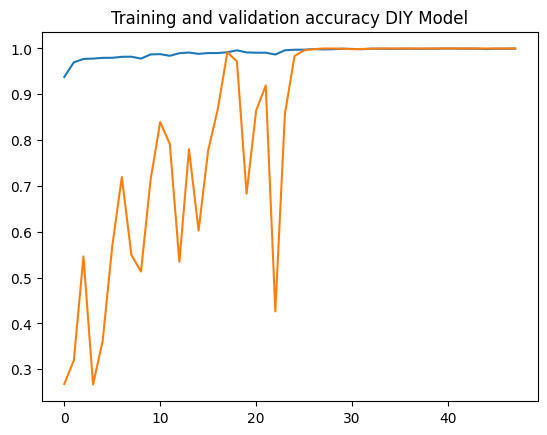

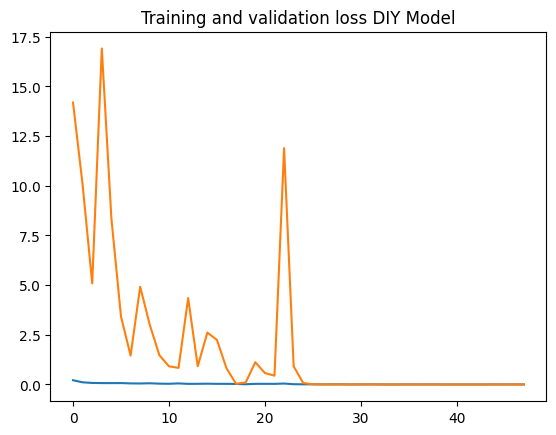

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')